# Null distributions and Test Statistics of regions with significance

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pickle

%matplotlib inline

import seaborn as sns

sns.set(color_codes=True, style="white", context="talk", font_scale=1)
PALETTE = sns.color_palette("Set1")

from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS
from hyppo.independence import Dcorr
from scipy.stats import multiscale_graphcorr
from hyppo.ksample._utils import k_sample_transform
from graspy.plot import heatmap, pairplot

import sys

sys.path.append("../")
from src.tools.utils import get_files, get_latents

%load_ext autoreload
%autoreload 2
%load_ext nb_black

/home/rflperry/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [10]:
## Define paths, get raw
base_dir = Path("/mnt/ssd3/ronan/data/gcca_05-26-10:39_min_rank-ZG3/")
groups, labels = get_latents(base_dir, flag="_gcca")

## Save path
save_dir = Path("../data/2sample_tests")

<IPython.core.display.Javascript object>

In [3]:
y = np.repeat(labels, [len(g) for g in groups], axis=0)
label_transform = {
    "e": "Expert",
    "n": "Novice",
    "compassion": "Compasson",
    "restingstate": "Resting",
    "openmonitoring": "Open",
}

<IPython.core.display.Javascript object>

In [4]:
labels

[['e', 'restingstate'],
 ['e', 'openmonitoring'],
 ['e', 'compassion'],
 ['n', 'restingstate'],
 ['n', 'openmonitoring'],
 ['n', 'compassion']]

<IPython.core.display.Javascript object>

In [16]:
# #### OUTDATED
# ## Test Case: [Labels (-1 means ignore), gradients used]
# significant_cases = {
#     "Experts vs. Novices (G1)": [[0, 0, 0, 1, 1, 1], [0]],
#     "Experts vs. Novices (G2)": [[0, 0, 0, 1, 1, 1], [1]],
#     "Experts vs. Novices (G3)": [[0, 0, 0, 1, 1, 1], [2]],
#     "Experts vs. Novices (G1,G2)": [[0, 0, 0, 1, 1, 1], [0, 1]],
#     "Experts vs. Novices (G1,G3)": [[0, 0, 0, 1, 1, 1], [0, 2]],
#     "Experts vs. Novices (G2,G3)": [[0, 0, 0, 1, 1, 1], [1, 2]],
#     "Experts vs. Novices (G1,G2,G3)": [[0, 0, 0, 1, 1, 1], [0, 1, 2]],
#     "Experts Meditating vs. Novices Resting (G2)": [[-1, 0, 0, 1, -1, -1], [1]],
#     "Experts Meditating vs. Novices Resting (G3)": [[-1, 0, 0, 1, -1, -1], [2]],
#     "Experts Meditating vs. Novices Resting (G1,G2)": [[-1, 0, 0, 1, -1, -1], [0, 1]],
#     "Experts Meditating vs. Novices Resting (G1,G2,G3)": [
#         [-1, 0, 0, 1, -1, -1],
#         [0, 1, 2],
#     ],
# }

# sig_results = {}

# for key, (labels, grads) in significant_cases.items():
#     ## Make data
#     ways = [[w] for w in labels if w != -1]
#     X, Y = k_sample_transform(
#         [np.asarray(groups[i]) for i, w in enumerate(labels) if w != -1], ways=ways
#     )
#     X = X[:, :, grads].reshape(X.shape[0], -1)

#     ## Test
#     X_dists = pairwise_distances(X, metric="euclidean")
#     Y_dists = pairwise_distances(Y, metric="sqeuclidean") / 2

#     stat, pvalue, mgc_dict = multiscale_graphcorr(
#         X_dists,
#         Y_dists,
#         workers=-1,
#         reps=10000,
#         compute_distance=None,
#         compute_c_mat=True,
#     )
#     print(f"pvalue: {pvalue}")

#     ## Store
#     sig_results[key] = {
#         "pvalue": pvalue,
#         "test_stat": stat,
#         "null_dist": mgc_dict["null_dist"],
#         "opt_scale": mgc_dict["opt_scale"],
#         "c_mat": mgc_dict["c_mat"],
#     }
    
# with open(save_dir / "significant_test_nulls.pkl", "wb") as f:
#     pickle.dump(sig_results, f, protocol=pickle.HIGHEST_PROTOCOL)

<IPython.core.display.Javascript object>

## Test statistic Null distributions

In [11]:
with open(save_dir / "MGC_results_dict_10000_min_rank-ZG3.pkl", "rb") as f:
    result_dict = pickle.load(f)

<IPython.core.display.Javascript object>

In [15]:
result_dict["Experts Resting vs. Experts Compassion"][0]

{'pvalue': 0.9718,
 'test_stat': -0.03901753295542519,
 'null_dist': array([ 0.00963221,  0.05165546, -0.02523735, ..., -0.01802851,
         0.04769927, -0.02912019]),
 'opt_scale': [58, 2]}

<IPython.core.display.Javascript object>

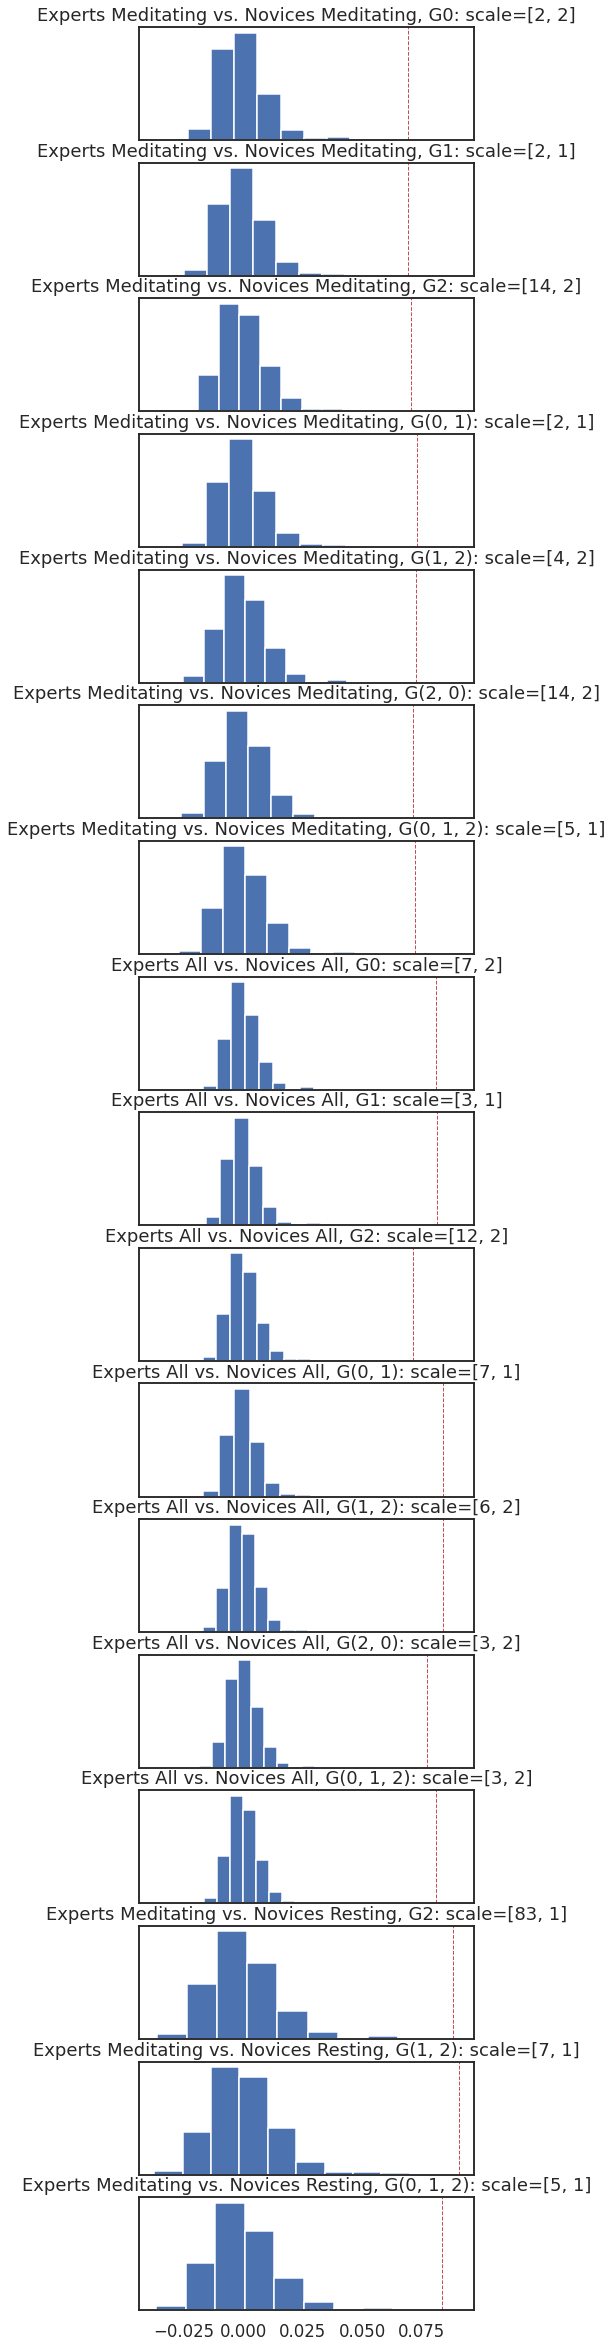

<IPython.core.display.Javascript object>

In [31]:
ALPHA = 0.05
BF_CORRECTION = 7 * 25

n_plots = 0

for comparison, grad_dict in result_dict.items():
    for grads, stat_dict in grad_dict.items():
        if stat_dict["pvalue"] < ALPHA / BF_CORRECTION:
            n_plots += 1

fig, axes = plt.subplots(n_plots, 1, sharex=True, figsize=(6, 42))
ax_idx = 0

for comparison, grad_dict in result_dict.items():
    for grads, stat_dict in grad_dict.items():
        if stat_dict["pvalue"] < ALPHA / BF_CORRECTION:
            ax = axes[ax_idx]
            ax.hist(stat_dict["null_dist"])
            ax.axvline(
                stat_dict["test_stat"], color="r", linestyle="dashed", linewidth=1
            )
            ax.set_title(f'{comparison}, G{grads}: scale={stat_dict["opt_scale"]}')
            ax.set_yticks([])
            ax_idx += 1
plt.show()